In [1]:
library(tidyverse)
library(stringr)
library(cowplot)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




# Plotting
## Load Data

In [2]:
df <- read_csv("../Data/ODE_sim.csv", col_names = c("psw","N","temp","t","treat","rep","drep")) %>%
    mutate(t = case_when(t == 1 ~ "initial", t == 2 ~ "dispersal",t == 3 ~ "kinetic")) %>%
    mutate(t = factor(t, levels = c("initial","dispersal","kinetic")))

#species data
sp_data <- read_csv("../Data/ODE_sp.csv", col_names = c("sp_id","location","temp","Tpk","n","M","c","r","mass","t","treat","rep","drep")) %>%
    mutate(t = case_when(t == 1 ~ "initial", t == 2 ~ "dispersal",t == 3 ~ "kinetic")) %>%
    mutate(t = factor(t, levels = c("initial","dispersal","kinetic"))) %>%
    mutate(location = str_split(gsub("\\[|\\]", "", location),pattern = ","),
           temp = str_split(gsub("\\[|\\]", "", temp),pattern = ",")) %>%
    unnest(c(location, temp)) %>%
    mutate_at(vars(location,temp), as.numeric)

Rows: 1350000 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): psw, N, temp, t, treat, rep, drep

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 40500000 Columns: 13
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): location, temp
dbl (11): sp_id, Tpk, n, M, c, r, mass, t, treat, rep, drep

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
df <- df %>% arrange(rep,drep,treat,t,temp) %>% group_by(rep,drep,treat,t) %>% mutate(location = row_number())

In [4]:
sp_nest <- sp_data %>% filter(location != 0) %>% group_by(rep,drep,treat,t,location) %>% nest()
df_nest <- df %>% group_by(rep,drep,treat,t,location) %>% nest() %>% rename(com_data = data)

In [5]:
df_full <- full_join(sp_nest, df_nest) %>%
    unnest(c(data, com_data), names_sep = "_")

df_full <- df_full %>%  group_by(rep,drep,treat,t,location) %>% mutate(uM_log = mean(log10(data_M)), uM = mean(data_M))

df_full %>% head()

Joining with `by = join_by(location, t, treat, rep, drep)`


location,t,treat,rep,drep,data_sp_id,data_temp,data_Tpk,data_n,data_M,data_c,data_r,data_mass,com_data_psw,com_data_N,com_data_temp,uM_log,uM
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
46,initial,-0.75,1,1,1,1.163935,1.163935,0.99943010,41.910631,0.98497400,0.18151626,1,0.7,30,1.163935,0.7432997,9.277936
46,initial,-0.75,1,1,63,1.163935,1.163935,0.56514266,8.267371,0.54877620,0.54414253,1,0.7,30,1.163935,0.7432997,9.277936
46,initial,-0.75,1,1,124,1.163935,1.163935,0.06559049,1.277820,0.04734476,0.03373551,1,0.7,30,1.163935,0.7432997,9.277936
46,initial,-0.75,1,1,135,1.163935,1.163935,0.60756099,9.687750,0.31008560,0.06815118,1,0.7,30,1.163935,0.7432997,9.277936
46,initial,-0.75,1,1,174,1.163935,1.163935,0.59096582,9.105103,0.37815109,0.34868931,1,0.7,30,1.163935,0.7432997,9.277936
46,initial,-0.75,1,1,216,1.163935,1.163935,0.34480423,3.628300,0.14853498,0.05224251,1,0.7,30,1.163935,0.7432997,9.277936


## Fig 1) PSW over temperature

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


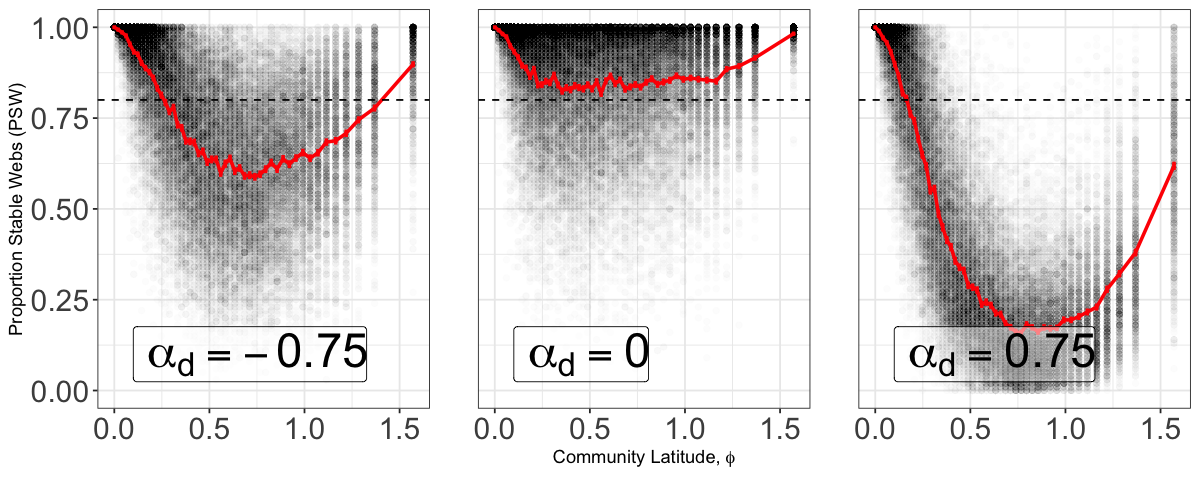

In [88]:
options(repr.plot.width=10, repr.plot.height=4)

dat_text <- data.frame(
  label = c("alpha[d] == -0.75 ","alpha[d] == 0 ","alpha[d] == 0.75 "),
  treat   = c(-0.75, 0.0, 0.75)
)

psw_plot <- df %>%
    filter(t == "dispersal", treat %in% c(0.75,0.0,-0.75)) %>%
    # group_by(treat,rep,temp) %>%
    # summarise(psw = mean(psw)) %>%
    ggplot(aes((temp), psw, group = treat))+
        geom_point(alpha=0.01)+
        stat_summary(geom = "line", fun = "mean", color = "red", linewidth = 1)+
        stat_summary(geom = "errorbar", color = "red", linewidth = 1)+
        geom_hline(yintercept = 0.8, linetype = "dashed")+            
# geom_smooth(se = FALSE)+
        theme_bw()+
        facet_wrap(~treat)+
        xlab(expression(paste("Community Latitude, ",phi)))+
        ylab("Proportion Stable Webs (PSW)")+
        theme(legend.position = "none",axis.text = element_text(size = 18), strip.background = element_blank(), strip.text = element_blank(), panel.spacing = unit(2, "lines"))+
        geom_label(aes(label = label), x = 0.1,y = 0.1, data = dat_text, parse = TRUE,size = 10, hjust = "left", fill = alpha(c("white"),0.5))

ggsave("../Figures/f1_psw.pdf", psw_plot, width = 12, height = 4)

psw_plot

## Fig 2) N over temperature

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


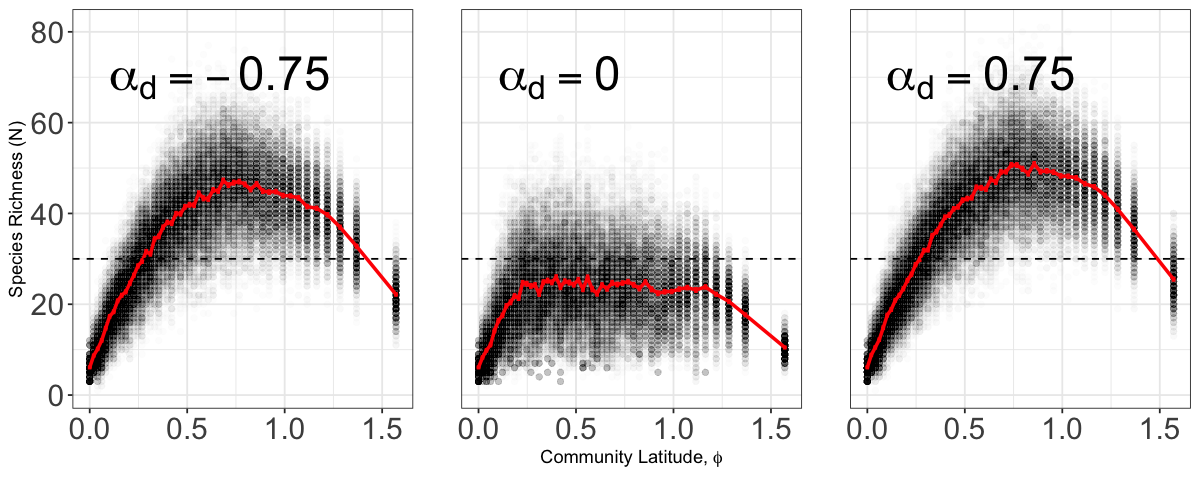

In [89]:
options(repr.plot.width=10, repr.plot.height=4)

dat_text <- data.frame(
  label = c("alpha[d] == -0.75","alpha[d] == 0","alpha[d] == 0.75"),
  treat   = c(-0.75, 0.0, 0.75)
)

psw_plot <- df %>%
    filter(t == "dispersal", treat %in% c(0.75,0.0,-0.75)) %>%
    # group_by(treat,rep,temp) %>%
    # summarise(psw = mean(psw)) %>%
    ggplot(aes((temp), N, group = treat))+
        geom_point(alpha=0.01)+
        stat_summary(geom = "line", fun = "mean", color = "red", linewidth = 1)+
        stat_summary(geom = "errorbar", color = "red", linewidth = 1)+
        geom_hline(yintercept = 30, linetype = "dashed")+            
        # geom_smooth(se = FALSE)+
        theme_bw()+
        facet_wrap(~treat)+
        xlab(expression(paste("Community Latitude, ",phi)))+
        ylab("Species Richness (N)")+
        theme(legend.position = "none",axis.text = element_text(size = 18), strip.background = element_blank(), strip.text = element_blank(), panel.spacing = unit(2, "lines"))+
        geom_text(aes(label = label), x = 0.1,y = 70, data = dat_text, parse = TRUE,size = 10, hjust = "left")

ggsave("../Figures/f2_N.pdf", psw_plot, width = 12, height = 4)

psw_plot

In [9]:
df_com <- df_full %>%
    filter(t == "dispersal", com_data_psw > 0, com_data_psw < 1) %>%
    select(location,t,treat,rep,drep,com_data_temp,com_data_psw,com_data_N,uM, uM_log) %>%
    distinct()

No summary function supplied, defaulting to `mean_se()`


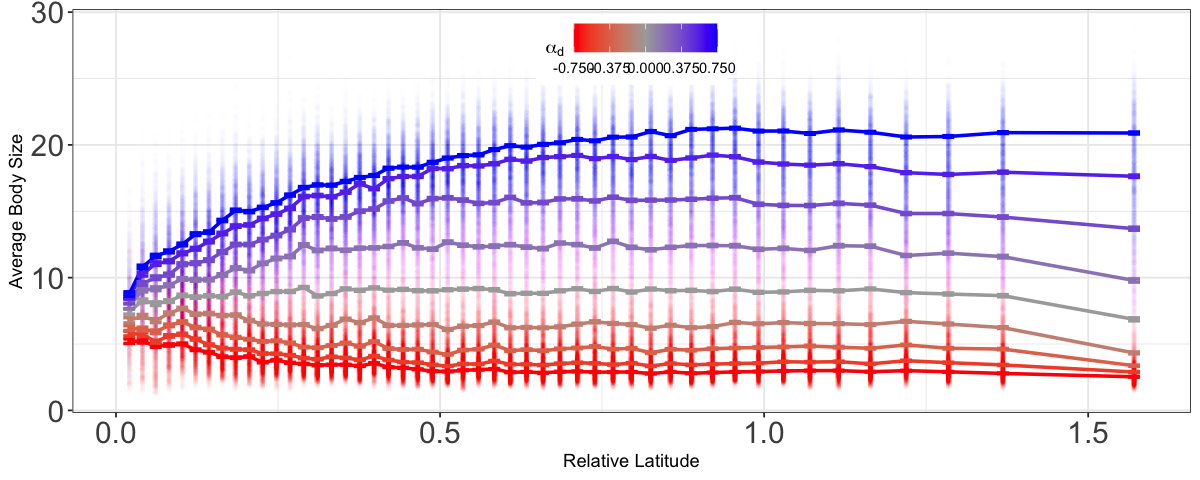

In [99]:
bs_lat <- df_com %>%
     # filter(treat %in% c(0.75,0.0,-0.75)) %>%
    ggplot(aes((com_data_temp), uM, color = treat, group = treat))+
        geom_point(alpha=0.005)+
        stat_summary(geom = "line", fun = "mean" , linewidth = 1)+
        stat_summary(geom = "errorbar", linewidth = 1)+
        # geom_smooth(se = FALSE)+
        theme_bw()+
        xlab("Relative Latitude")+
        ylab("Average Body Size")+
        scale_color_gradient2(low = "red", high = "blue", mid = "darkgrey", name = expression(paste(alpha[d])), breaks = seq(-0.75,0.75,length.out = 5))+
        theme(legend.position = c(0.5,0.9), legend.direction = "horizontal", axis.text = element_text(size = 18), strip.background = element_blank(), strip.text = element_blank(), panel.spacing = unit(2, "lines"))
bs_lat

# N vs psw - accounting for the difference

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


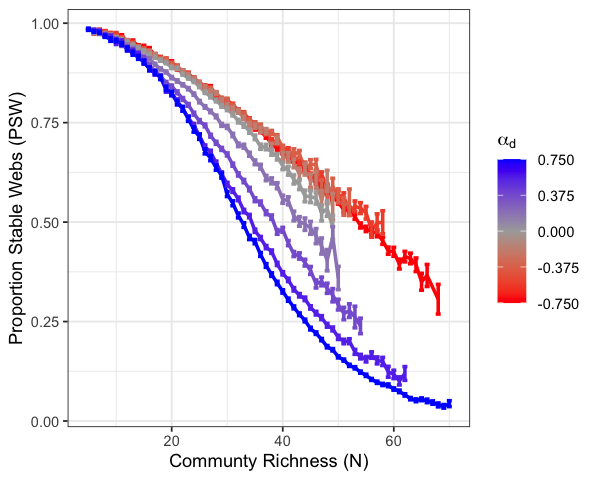

In [74]:
N_psw <- df_com %>% 
    filter(t == "dispersal") %>%
    # filter(com_data_psw > 0.0, com_data_psw < 1.0) %>% 
    # mutate(odds = log(com_data_psw / (1 - com_data_psw))) %>%
    group_by(com_data_N,treat) %>%
    filter(n() > 20) %>%
    ggplot(aes(com_data_N, com_data_psw, group = treat, color = treat)) +
        # geom_point(alpha = 0.005)+
        stat_summary(geom = "line", fun = "mean", linewidth = 1)+
        stat_summary(geom = "errorbar", linewidth = 1)+
        theme_bw()+
        scale_color_gradient2(low = "red", high = "blue", mid = "darkgrey", name = expression(paste(alpha[d])), breaks = seq(-0.75,0.75,length.out = 5))+
        # theme(legend.position = c(0.1,0.3))+
        xlab("Communty Richness (N)")+
        ylab("Proportion Stable Webs (PSW)")

ggsave("../Figures/f3_N_psw.pdf", N_psw, width = 4, height = 3)

N_psw

In [12]:
# df_full %>%
#     select(location,t,treat,rep,drep,psw = com_data_psw,N = com_data_N,uM) %>%
#     distinct() %>%
#     filter(t == "dispersal") %>%
#     filter(psw > 0.0, psw < 1.0) %>% 
#     mutate(odds = log(psw / (1 - psw)), uM_cut = cut(uM, 10)) %>%
#     group_by(N, uM_cut)
#     # filter(n() > 10) %>%
#     # summarise(m_psw = mean(psw), m_odds = mean(odds), uM = mean(uM)) %>%
#     # ggplot(aes(N, psw, color = uM, group = uM))+
#     #     geom_point()


No summary function supplied, defaulting to `mean_se()`


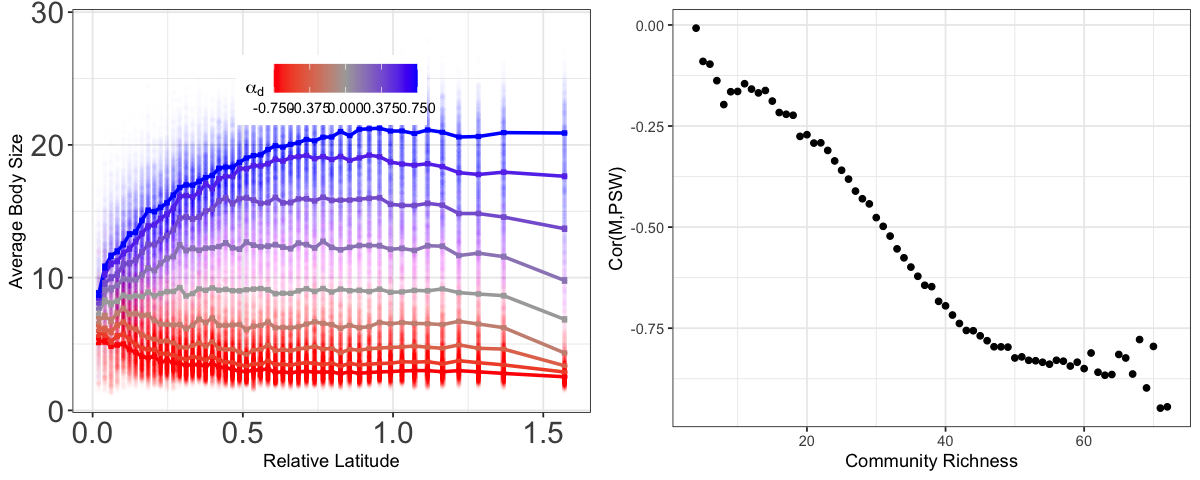

In [98]:
cor_plot <- df_full %>%
    select(location,t,treat,rep,drep,com_data_psw,com_data_N,uM) %>%
    distinct() %>%
    filter(t == "dispersal", com_data_psw > 0, com_data_psw < 1) %>%    
    mutate(odds = log(com_data_psw / (1 - com_data_psw))) %>%
    ungroup %>%
    group_by(com_data_N) %>%
    filter(n() > 20) %>%
    summarise(cor = cor(uM,com_data_psw)) %>%
    ggplot(aes(com_data_N, cor))+
        geom_point()+
        theme_bw()+
        xlab("Community Richness")+
        ylab("Cor(M,PSW)")

size_plot <- plot_grid(bs_lat, cor_plot)

size_plot

In [100]:
size_plot <- plot_grid(bs_lat, cor_plot)

ggsave("../Figures/f4_size.pdf", size_plot, width = 8, height = 4)


No summary function supplied, defaulting to `mean_se()`


`summarise()` has grouped output by 'com_data_N'. You can override using the `.groups` argument.


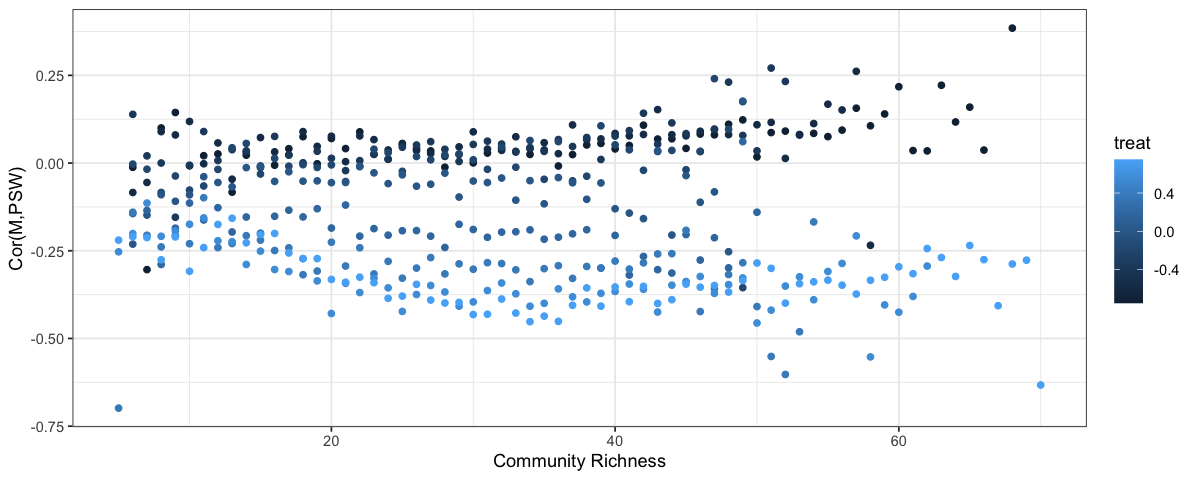

In [14]:
df_full %>%
    select(location,t,treat,rep,drep,com_data_psw,com_data_N,uM) %>%
    distinct() %>%
    filter(t == "dispersal", com_data_psw > 0, com_data_psw < 1) %>%    
    mutate(odds = log(com_data_psw / (1 - com_data_psw))) %>%
    ungroup %>%
    group_by(com_data_N, treat) %>%
    filter(n() > 20) %>%
    summarise(cor = cor(uM,com_data_psw)) %>%
    ggplot(aes(com_data_N, cor, color = treat))+
        geom_point()+
        theme_bw()+
        xlab("Community Richness")+
        ylab("Cor(M,PSW)")

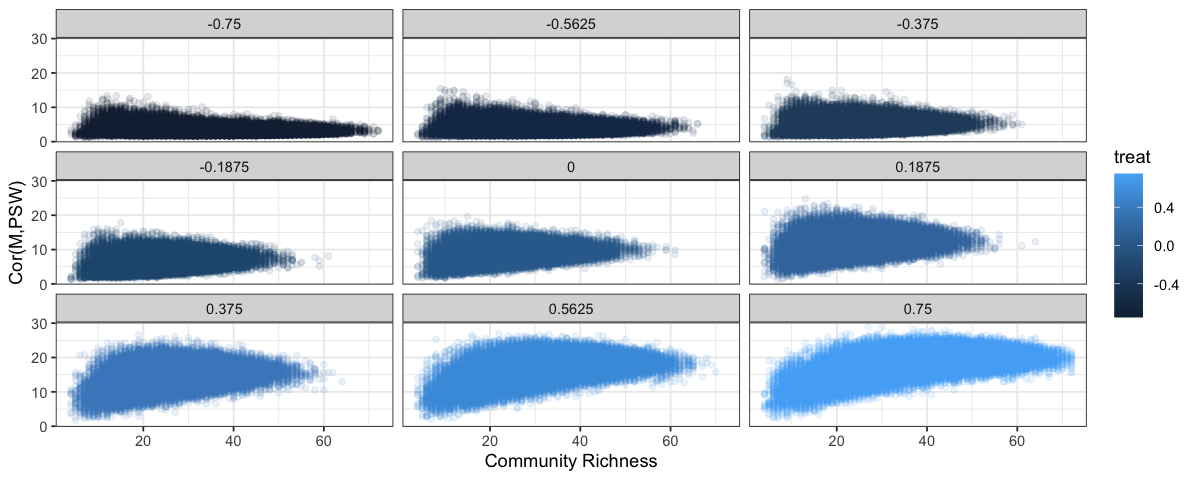

In [15]:
df_full %>%
    select(location,t,treat,rep,drep,com_data_psw,com_data_N,uM) %>%
    distinct() %>%
    filter(t == "dispersal", com_data_psw > 0, com_data_psw < 1) %>%   
    # filter(treat %in% c(0.75,0.0,-0.75)) %>%
    mutate(odds = log(com_data_psw / (1 - com_data_psw))) %>%
    ungroup %>%
    group_by(com_data_N) %>%
    filter(n() > 20) %>%
    ggplot(aes(com_data_N, uM, color = treat))+
        geom_point(alpha=0.1)+
        # stat_summary(geom = "line", fun = "mean")+
        theme_bw()+
        xlab("Community Richness")+
        ylab("Cor(M,PSW)")+
        facet_wrap(~treat)

No summary function supplied, defaulting to `mean_se()`


In [51]:
mod <- df_com %>%
    filter(t == "dispersal") %>%
    mutate(odds = log(com_data_psw / (1 - com_data_psw))) %>%
    lm(odds ~ com_data_N +  com_data_N:treat, data = .)

summary(mod)


Call:
lm(formula = odds ~ com_data_N + com_data_N:treat, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1541 -0.6728 -0.0540  0.6269  5.2134 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       4.498e+00  4.625e-03   972.6   <2e-16 ***
com_data_N       -1.061e-01  1.448e-04  -732.9   <2e-16 ***
com_data_N:treat -2.903e-02  8.946e-05  -324.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.004 on 393578 degrees of freedom
Multiple R-squared:  0.6344,	Adjusted R-squared:  0.6344 
F-statistic: 3.415e+05 on 2 and 393578 DF,  p-value: < 2.2e-16


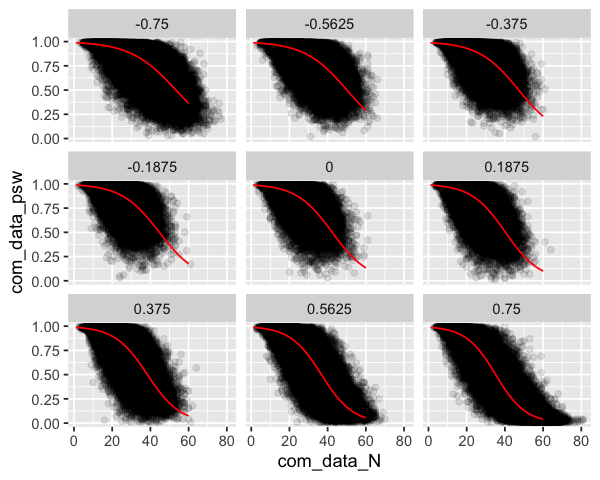

In [55]:
c <- coef(mod)

pred <- expand_grid(N = 1:60, treat = seq(-0.75,0.75, length.out = 9)) %>% mutate(odds = c[1] + c[2] * N + c[3] * N * treat, psw = 1 / (1 + exp(-odds)))

df_com %>%
    filter(t == "dispersal") %>%
    mutate(odds = log(com_data_psw / (1 - com_data_psw))) %>%
    ggplot(aes(com_data_N, com_data_psw))+
        geom_point(alpha = 0.1)+
        facet_wrap(~treat)+
        geom_line(data = pred, aes(N,psw), color = "red")

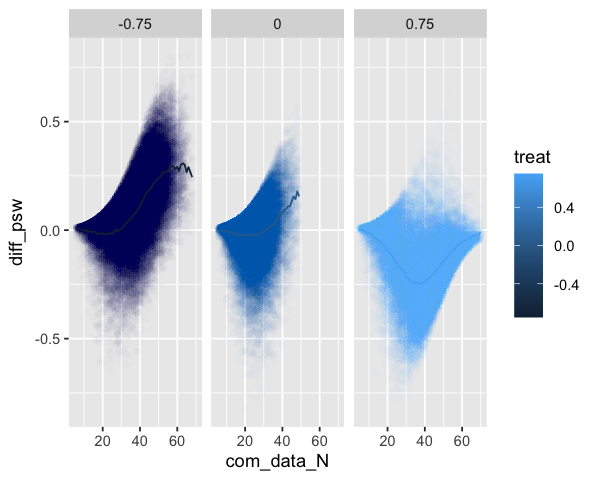

In [56]:
df_com %>%
    filter(t == "dispersal") %>%
    filter(treat %in% c(0.75,0.0,-0.75)) %>%
    group_by(com_data_N, treat) %>%
    filter(n() > 20) %>%
    mutate(pred_odds = c[1] + c[2] * com_data_N) %>%
    mutate(odds = log(com_data_psw / (1 - com_data_psw)), diff_odds = odds - pred_odds, diff_psw = com_data_psw - (1/(1 + exp(-pred_odds)))) %>%
    ggplot(aes(com_data_N, diff_psw, color = treat, group = treat)) +
        geom_point(alpha = 0.01) +
        stat_summary(geom = "line", fun = "mean") +
        facet_wrap(~treat)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?”


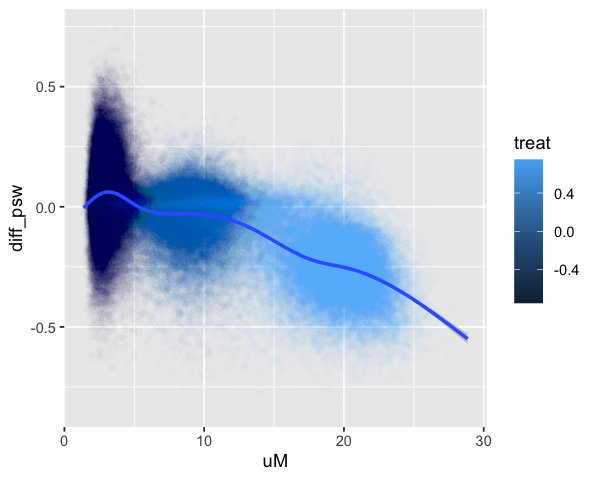

In [49]:
options(repr.plot.width=5, repr.plot.height=4)

df_com %>%
    filter(t == "dispersal") %>%
    filter(treat %in% c(0.75,0.0,-0.75)) %>%
    group_by(com_data_N, treat) %>%
    filter(n() > 100) %>%
    mutate(pred_odds = c[1] + c[2] * com_data_N) %>%
    mutate(odds = log(com_data_psw / (1 - com_data_psw)), diff_odds = odds - pred_odds, diff_psw = com_data_psw - (1/(1 + exp(-pred_odds)))) %>%
     ggplot(aes(uM, diff_psw, color = treat, group = treat)) +
        geom_point(alpha = 0.01)+
        geom_smooth(aes(group = NULL))


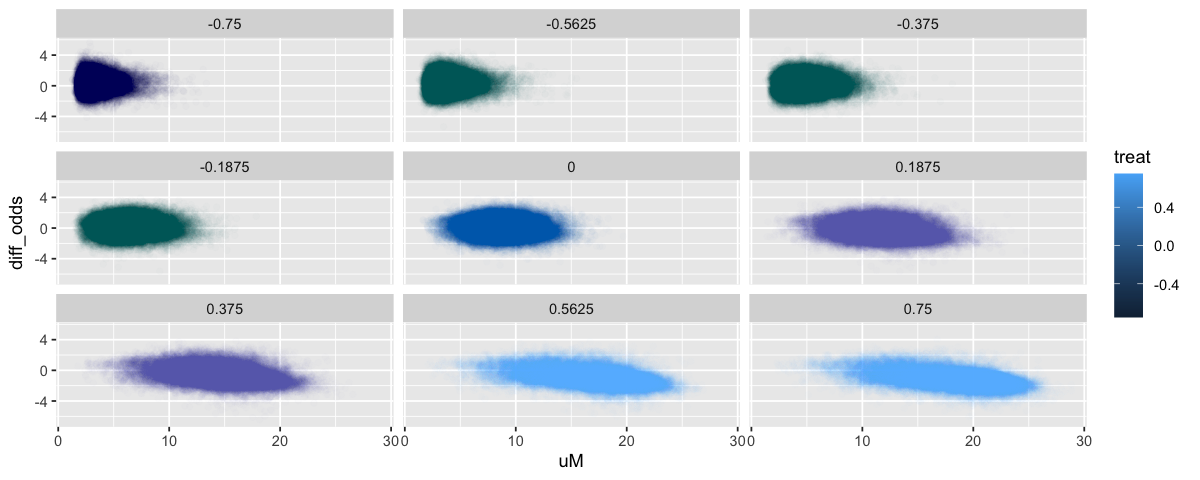

In [44]:
df_com %>%
    filter(t == "dispersal") %>%
    # filter(treat %in% c(0.75,0.0,-0.75)) %>%
    group_by(com_data_N, treat) %>%
    filter(n() > 20) %>%
    mutate(pred_odds = c[1] + c[2] * com_data_N) %>%
    mutate(odds = log(com_data_psw / (1 - com_data_psw)), diff_odds = odds - pred_odds, diff_psw = com_data_psw - (1/(1 + exp(-pred_odds)))) %>%
     ggplot(aes(uM, diff_odds, color = treat, group = treat)) +
        geom_point(alpha = 0.01) +
        # stat_summary(geom = "line", fun = "mean") +
        facet_wrap(~treat)